In [1]:
import os
import re
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad
from tqdm import tqdm
import pickle
import seaborn as sb
import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt
import sys
from matplotlib.pyplot import rc_context
import scipy as sp
import scipy
from scipy import sparse
from matplotlib import rcParams
import matplotlib.patches as mpatches

from PyQt5.QtCore import pyqtSlot, QSettings, QTimer, QUrl, QDir
from PyQt5.QtWidgets import QMainWindow, QFileDialog, QMessageBox, QApplication
matplotlib.use('Qt5Agg')

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

C:\Users\christos.karampelias\anaconda3\envs\scanpyR_scanorama\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.5 anndata==0.10.9 umap==0.5.4 numpy==1.26.4 scipy==1.14.1 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.10


In [3]:
adata=sc.read_10x_mtx('/Users/christos.karampelias/Desktop/SoupX corrected 8month organoids/soupX_8monthorganoids_filtered/')

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [4]:
adata

AnnData object with n_obs × n_vars = 8071 × 56060
    var: 'gene_ids', 'feature_types'

In [12]:
adata.var_names_make_unique()

In [6]:
#Merge -iso -ext -gn counts
features = pd.read_csv('features.tsv', header=None, sep='\t')
extensions = ['ext10kb', 'ext1kb', 'ext2kb', 'ext3kb', 'ext4kb', 'ext5kb','ext6kb', 'ext7kb', 'ext8kb', 'ext9kb', 'iso', 'gn']
gene_ids_noext = [gid.split('-')[0] for gid in features[0]]
gene_symbols_noext = [gid.split('-')[0] if gid.split('-')[-1] in extensions else gid for gid in features[1]]

In [7]:
adata.var_names = np.array(features[0])
adata.var['gene_symbols'] = np.array(features[1])
adata.var['gene_ids_noext'] = [gid.split('-')[0] for gid in gene_ids_noext]
adata.var['gene_symbols_noext'] = [gid.split('-')[0] for gid in gene_symbols_noext]

In [8]:
adata.X = adata.X.toarray()
gene_ids_for_selection = []
i = 0
for idx, group in tqdm(adata.var.groupby('gene_ids_noext')):
    gene_id_for_selection = group.index[0]
    if len(group) > 1:
            adata[:, gene_id_for_selection].X = adata[:, group.index].X.sum(axis=1)
    gene_ids_for_selection.append(gene_id_for_selection)
    i+=1

adata = adata[:, gene_ids_for_selection]

100%|██████████████████████████████████████████████████████████████████████████| 30286/30286 [00:10<00:00, 2982.58it/s]


In [9]:
extensions = ['ext10kb', 'ext1kb', 'ext2kb', 'ext3kb', 'ext4kb', 'ext5kb', 'ext6kb', 'ext7kb', 'ext8kb', 'ext9kb', 'iso','gn']
gene_ids_noext = [gid.split('-')[0] for gid in features[0]]
gene_symbols_noext = [gid.split('-')[0] if gid.split('-')[-1] in extensions else gid for gid in features[1]]
df = pd.DataFrame({'gene_ids_noext':gene_ids_noext, 'gene_symbols_noext': gene_symbols_noext}).drop_duplicates()
df = df.set_index('gene_ids_noext')
adata.var['gene_symbols'] = np.array(df.loc[adata.var['gene_ids_noext']]['gene_symbols_noext'])
adata.var = adata.var.set_index('gene_symbols')
adata.var_names = adata.var.index

C:\Users\christos.karampelias\AppData\Local\Temp\ipykernel_23708\743939540.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_symbols'] = np.array(df.loc[adata.var['gene_ids_noext']]['gene_symbols_noext'])


In [10]:
adata

AnnData object with n_obs × n_vars = 8071 × 30286
    var: 'gene_ids', 'feature_types', 'gene_ids_noext', 'gene_symbols_noext'

In [13]:
#QC control
sc.pp.filter_genes(adata, min_cells=3)

In [14]:
adata.var['mt'] = adata.var_names.str.startswith(("ENSSSCG00000018060","ENSSSCG00000018061","ENSSSCG00000018062","ENSSSCG00000018063-iso","ENSSSCG00000018064","ND1","ENSSSCG00000018066","ENSSSCG00000018067-iso","ENSSSCG00000018067-iso-ext10kb","ENSSSCG00000018068","ND2","ENSSSCG00000018070","ENSSSCG00000018071-iso","ENSSSCG00000018072","ENSSSCG00000018073","ENSSSCG00000018074","COX1","ENSSSCG00000018076-iso","ENSSSCG00000018077","COX2","ENSSSCG00000018079","ATP8","ATP6","COX3","ENSSSCG00000018083","ND3","ENSSSCG00000018085","ND4L","ND4","ENSSSCG00000018088","ENSSSCG00000018089","ENSSSCG00000018090","ND5","ND6","ENSSSCG00000018093","CYTB","ENSSSCG00000018095","ENSSSCG00000018095-ext10kb","ENSSSCG00000018096","ENSSSCG00000018096-ext1kb"))

In [15]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [16]:
def add_qc_metrics(adata):
    # Quality control - calculate QC covariates
    adata.obs['n_counts'] = adata.X.sum(1)
    adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
    adata.obs['n_genes'] = (adata.X > 0).sum(1)
    return adata

In [17]:
adata = add_qc_metrics(adata)

C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_anndata.py:842: FutureWarning: 

Passing `palette`

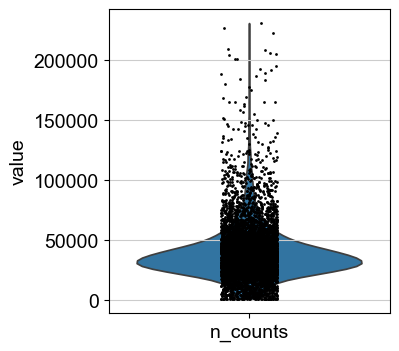

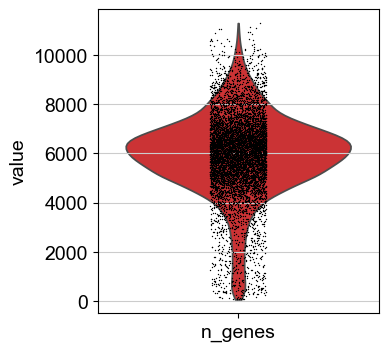

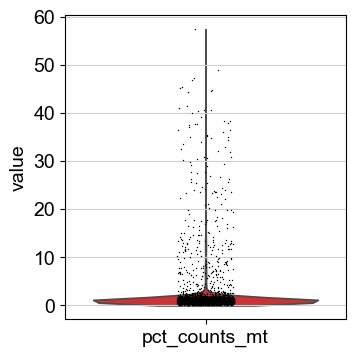

In [18]:
%matplotlib inline
rcParams['figure.figsize']=(4,4)
sc.pl.violin(adata, 'n_counts', size=2, log=False, cut=0, show=False)
plt.savefig("qccounts_8monthorganoids.png",bbox_inches="tight")
sc.pl.violin(adata, 'n_genes',  palette='Set1', show=False)
plt.savefig("qcgenes_8monthorganoids.png",bbox_inches="tight")
sc.pl.violin(adata, 'pct_counts_mt',  palette='Set1', log=False, show=False)
plt.savefig("qcmt_8monthorganoids.png",bbox_inches="tight")

C:\Users\christos.karampelias\AppData\Local\Temp\ipykernel_23708\3360000208.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p4 = sb.distplot(adata.obs['pct_counts_mt'][adata.obs['pct_counts_mt']<10], kde=False, bins=60)


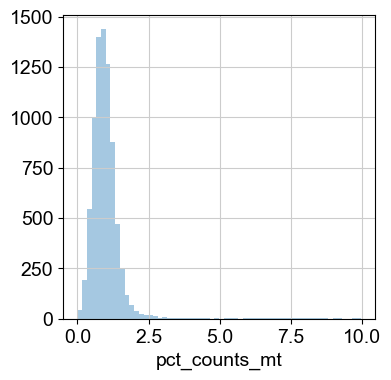

In [19]:
%matplotlib inline
p4 = sb.distplot(adata.obs['pct_counts_mt'][adata.obs['pct_counts_mt']<10], kde=False, bins=60)
plt.show()

C:\Users\christos.karampelias\AppData\Local\Temp\ipykernel_23708\4185492119.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<20000], kde=False, bins=60)


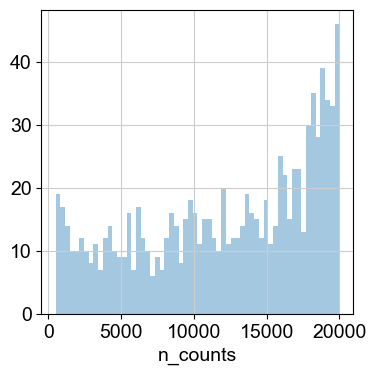

In [20]:
%matplotlib inline
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<20000], kde=False, bins=60)
plt.show()

C:\Users\christos.karampelias\AppData\Local\Temp\ipykernel_23708\463855292.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>6000], kde=False, bins=60)


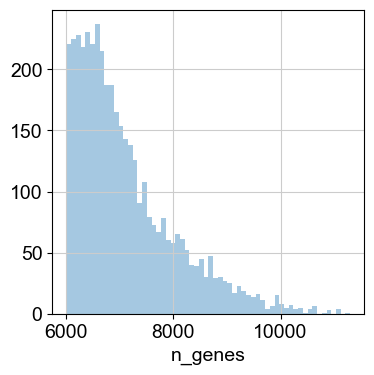

In [21]:
sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>6000], kde=False, bins=60)
plt.show()

In [22]:
#Start of filtering
adata = adata[adata.obs.pct_counts_mt < 3, :]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Number of cells after MT filter: 7773


In [23]:
adata = adata[adata.obs.n_genes_by_counts < 9000, :]
adata = adata[adata.obs.n_genes_by_counts > 1000, :]
print('Number of cells after Gene filter: {:d}'.format(adata.n_obs))

Number of cells after Gene filter: 7486


In [24]:
#Normalization and clustering
adata.layers["counts"] = adata.X.copy()

C:\Users\christos.karampelias\AppData\Local\Temp\ipykernel_23708\1355864533.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [25]:
sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed=True)
sc.pp.log1p(adata)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['GAPDH', 'KRTDAP', 'FABP5', 'S100A2', 'ENSSSCG00000006588', 'S100A8', 'ENSSSCG00000014540', 'ENSSSCG00000017445', 'ENSSSCG00000017448', 'S100A12', 'ENSSSCG00000044834', 'ENSSSCG00000047299', 'ENSSSCG00000048856']
    finished (0:00:00)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\preprocessing\_highly_variable_genes.py:247: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


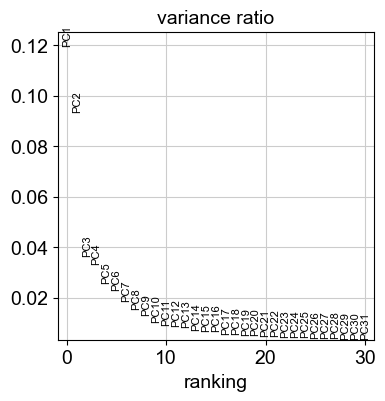

In [26]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata)

In [27]:
N_PCS=20
sc.pp.neighbors(adata,n_pcs = N_PCS)
sc.tl.umap(adata)
sc.tl.leiden(adata,key_added = "leiden_0.5", resolution=0.5)
sc.tl.leiden(adata,key_added = "leiden_0.4", resolution=0.4)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:00)


C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


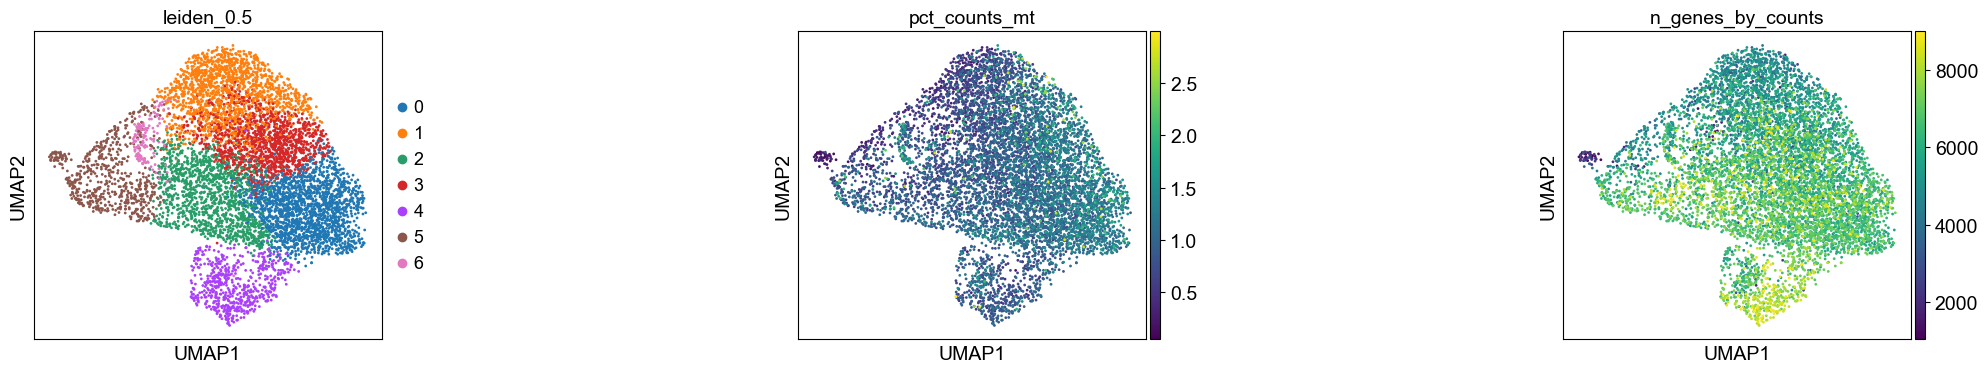

<Figure size 400x400 with 0 Axes>

In [28]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=['leiden_0.5', 'pct_counts_mt', 'n_genes_by_counts' ], wspace=1)
    plt.savefig("cluster_qc.png")

In [29]:
sc.tl.rank_genes_groups(adata, 'leiden_0.5',  method='wilcoxon')

ranking genes


C:\Users\christos.karampelias\anaconda3\envs\scanpyR_scanorama\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:24)


In [30]:
markergenescluster = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)
markergenescluster.to_csv("markergeneclusters_0point5leiden.csv")

In [31]:
new_cluster_names = [
    "WNT signaling enriched cells",
    "Glycolysis enriched cells 1",
    "Basal epithelial cells",
    "Glycolysis enriched cells 2",
    "Proliferating cells",
    "Pancreatic ductal cells 1",
    "Pancreatic ductal cells 2"
]

In [32]:
adata.rename_categories("leiden_0.5", new_cluster_names)

In [33]:
adata.write('240327_pn240pigorg_afterQC_anno.h5ad')

C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\get\get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\get\get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\get\get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. 

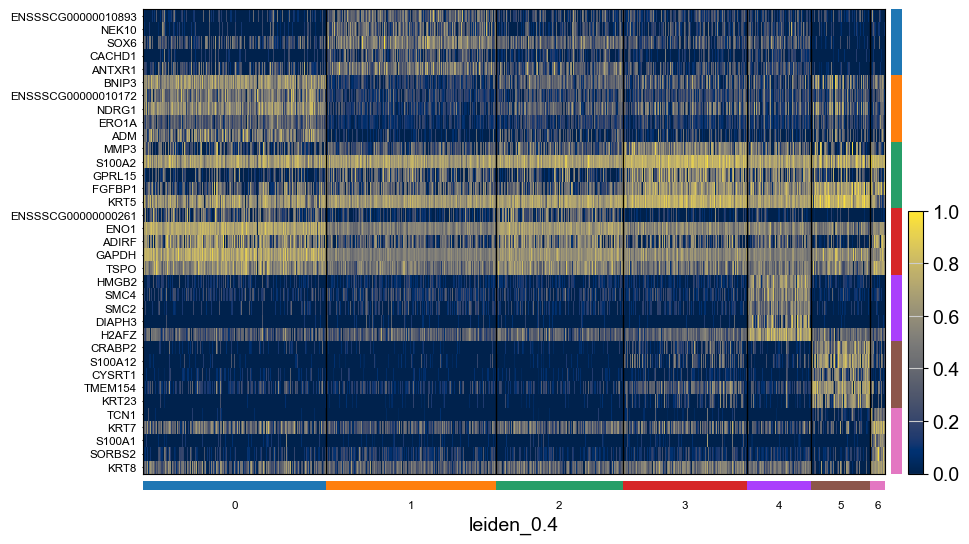

In [34]:
%matplotlib inline
with rc_context({'figure.figsize': (16, 16), 'font.size': 10}):
    sc.pl.rank_genes_groups_heatmap(adata, groupby='leiden_0.4', n_genes=5, standard_scale='var',cmap="cividis", 
    swap_axes=True, dendrogram=False, show_gene_labels=True, show=False)
    plt.savefig("240327_heatmapmarkers_pn240pigorgorg_0point5leiden.eps",bbox_inches="tight")

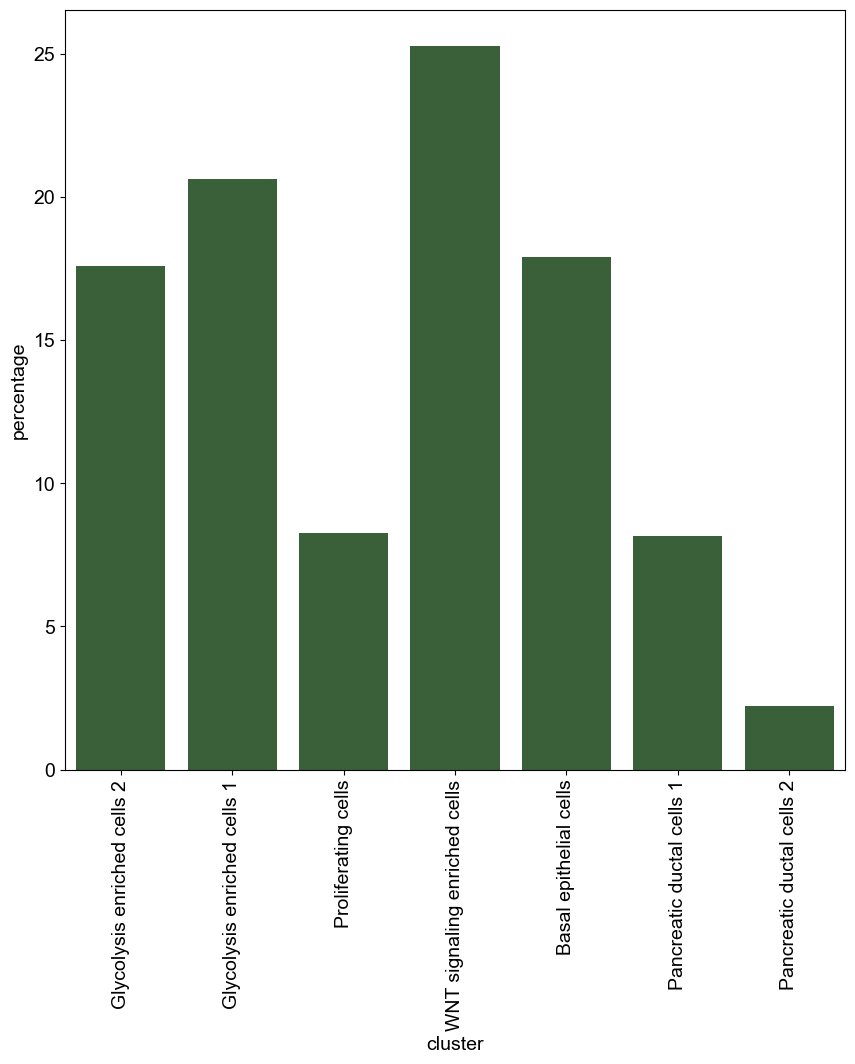

In [35]:
data={}
for v in adata.obs['leiden_0.5'].unique():
    data[v]=adata[adata.obs['leiden_0.5']==v].shape[0]/adata.shape[0]*100
df = pd.DataFrame.from_dict(data,orient='index',columns=['percentage'])    
df['cluster']=df.index
df=df.reset_index(drop=True)
color = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         ) 
with rc_context({'figure.figsize': (10, 10)}):
    p1 = sb.barplot(data=df, x='cluster', y='percentage', color=color),plt.xticks(rotation=90)
    plt.grid(False)
    plt.savefig("240327_cluster_percentage_pn240pigorg.eps", bbox_inches='tight')

In [36]:
notch_genes = ['NOTCH1','NOTCH2','NOTCH3','NOTCH4', 'DLL1', 'DLL3','DLL4','JAG1','JAG2','MAML1','MAML3', 'HES1','HES2', 'HES3','HES4', 'HES6', 'HES7']
hippo_genes = ['YAP1', 'TEAD1','TEAD2', 'TEAD3', 'TEAD4', 'TAZ', 'MST1', 'SAV1' ]
wnt_genes = ['FZD1', 'FZD2', 'FZD3', 'FZD4', 'FZD5', 'FZD6', 'FZD7', 'FZD8', 'FZD9', 'FZD10','LGR4','LGR5','LGR6',  'CTNNB1', 'TCF7', 'LEF1',  'TCF7L2']
lineagegenes = ['KRT7', 'SLC4A4','BMPR1A', 'ENSSSCG00000006525','SOX9', 'SST', 'CHGA', 'NEUROG3', 'GP2', 'CPA1',  'PLVAP','FLT1','COL1A2', 'PTPRC', 'CD2', 'CDH19']

C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap'

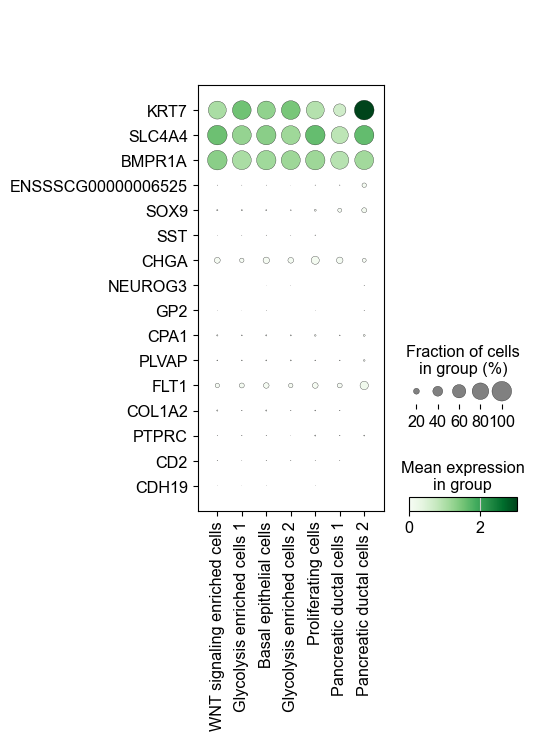

In [37]:
%matplotlib inline
sc.pl.dotplot(adata, lineagegenes, groupby='leiden_0.5' , cmap='Greens', swap_axes= True, show=False)
plt.savefig("240327_pn240pigorg_lineage genes.eps", bbox_inches='tight')

C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap'

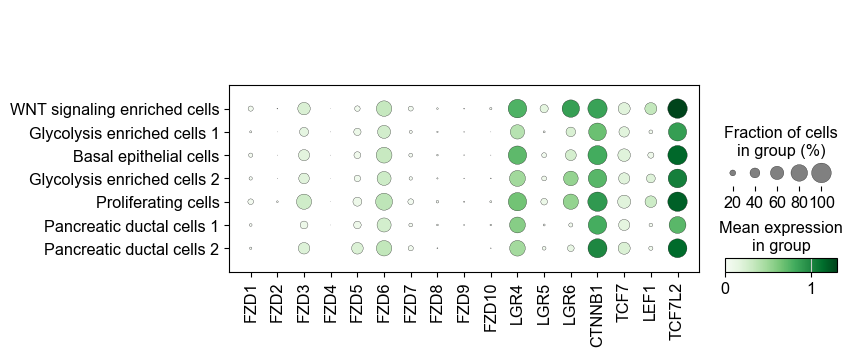

In [38]:
%matplotlib inline
sc.pl.dotplot(adata, wnt_genes, groupby='leiden_0.5' , cmap='Greens', swap_axes= False, show=False)
plt.savefig("240327_pn240pigorg_wnt genes.eps", bbox_inches='tight')

C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap'

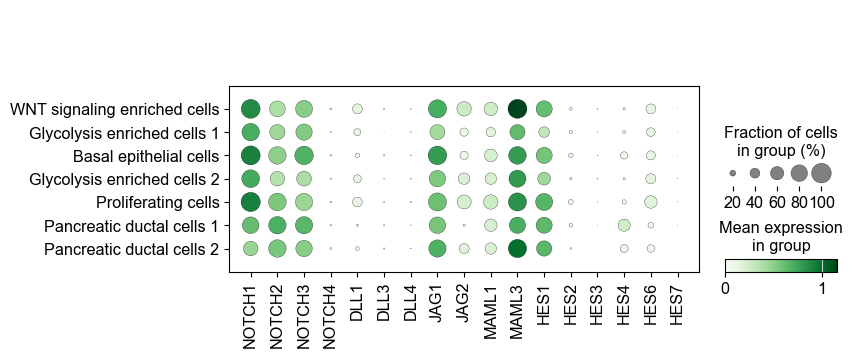

In [39]:
%matplotlib inline
sc.pl.dotplot(adata, notch_genes, groupby='leiden_0.5' , cmap='Greens', swap_axes= False, show=False)
plt.savefig("240327_pn240pigorg_notch genes.eps", bbox_inches='tight')

C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\christos.karampelias\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap'

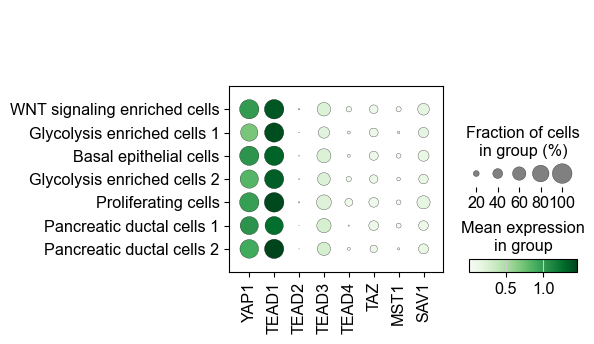

In [40]:
%matplotlib inline
sc.pl.dotplot(adata, hippo_genes, groupby='leiden_0.5' , cmap='Greens', swap_axes= False, show=False)
plt.savefig("240327_pn240pigorg_hippo genes.eps", bbox_inches='tight')

In [41]:
#LIANA cell-cell communication
import liana as li
from liana.mt import rank_aggregate
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

In [42]:
#LIANA homology test
resource = li.rs.select_resource('consensus')
resource.head()

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
3,LGALS9,LRP1
4,LGALS9,CD47


In [43]:
map_df = li.rs.get_hcop_orthologs(url='https://ftp.ebi.ac.uk/pub/databases/genenames/hcop/human_pig_hcop_fifteen_column.txt.gz',
                                   columns=['human_symbol', 'pig_symbol'],
                                   min_evidence=3
                                   )
# rename the columns to source and target, respectively for the original organism and the target organism
map_df = map_df.rename(columns={'human_symbol':'source', 'pig_symbol':'target'})
map_df.tail()

,source,target
31079,ZYG11A,ZYG11A
31080,ZYG11B,ZYG11B
31081,ZYX,ZYX
31082,ZZEF1,ZZEF1
31083,ZZZ3,ZZZ3


In [44]:
pig = li.rs.translate_resource(resource,
                                 map_df=map_df,
                                 columns=['ligand', 'receptor'],
                                 replace=True,
                                 one_to_many=3
                                 )
pig

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
4,LGALS9,CD47
5,LGALS9,PTPRK
...,...,...
4617,INHBA,ACTR2
4618,BMP7,ACTR2
4619,BMP2,ACTR2
4620,BMP15,ACTR2


In [45]:
# Run rank_aggregate
li.mt.rank_aggregate(adata,
                     groupby='leiden_0.5',
                     resource_name='pig',
                     resource=pig,
                     use_raw= False,
                     expr_prop=0.1,
                     verbose=True)

Using `.X`!
Converting to sparse csr matrix!


Using provided `resource`.


C:\Users\christos.karampelias\anaconda3\envs\scanpyR_scanorama\Lib\site-packages\anndata\_core\anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
1 features of mat are empty, they will be removed.
C:\Users\christos.karampelias\anaconda3\envs\scanpyR_scanorama\Lib\site-packages\liana\method\_pipe_utils\_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
C:\Users\christos.karampelias\anaconda3\envs\scanpyR_scanorama\Lib\site-packages\liana\method\_pipe_utils\_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
['Y_RNA', 'Y_RNA-1', '5S_rRNA', 'Y_RNA-2', 'Y_RNA-3', 'Y_RNA-4', 'Y_RNA-5', 'RNaseP_nuc', 'RNaseP_nuc-1', 'Metazoa_SRP', 'Metazoa_SRP-1', 'Metazoa_SRP-2', 'Metazoa_SRP-3', 'Metazoa_

Generating ligand-receptor stats for 7486 samples and 1270 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


C:\Users\christos.karampelias\anaconda3\envs\scanpyR_scanorama\Lib\site-packages\liana\method\sc\_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 45.36it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [46]:
myplot = li.pl.dotplot(adata = adata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              source_labels=['Pancreatic ductal cells 1', 'Pancreatic ductal cells 2', 'Glycolysis enriched cells 1', 'Glycolysis enriched cells 2', 'Basal epithelial cells', 'Proliferating cells'],
              target_labels=['WNT signaling enriched cells'],
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              cmap ='Greens',
              figure_size=(12, 12)
             )

C:\Users\christos.karampelias\anaconda3\envs\scanpyR_scanorama\Lib\site-packages\liana\plotting\_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
myplot.save('240420_pn240pigorg_LIANA plot to wnt cells.pdf')

C:\Users\christos.karampelias\anaconda3\envs\scanpyR_scanorama\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 12 x 12 in image.
C:\Users\christos.karampelias\anaconda3\envs\scanpyR_scanorama\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: 240420_pn240pigorg_LIANA plot to wnt cells.pdf
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


In [48]:
myplot1 = li.pl.dotplot(adata = adata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              source_labels=['WNT signaling enriched cells', 'Glycolysis enriched cells 1', 'Glycolysis enriched cells 2', 'Basal epithelial cells', 'Proliferating cells'],
              target_labels=['Pancreatic ductal cells 1', 'Pancreatic ductal cells 2'],
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              cmap ='Greens',
              figure_size=(20, 20)
             )

C:\Users\christos.karampelias\anaconda3\envs\scanpyR_scanorama\Lib\site-packages\liana\plotting\_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
myplot1.save('240420_pn240pigorg_LIANA plot to ductal cells.pdf')

C:\Users\christos.karampelias\anaconda3\envs\scanpyR_scanorama\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 20 x 20 in image.
C:\Users\christos.karampelias\anaconda3\envs\scanpyR_scanorama\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: 240420_pn240pigorg_LIANA plot to ductal cells.pdf
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
